<a href="https://colab.research.google.com/github/atharva-ketkar1/Retinal_Vessal_Segmentation/blob/main/retinal_vessal_seg_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Retinal_Vessal_Segmentation
#!git clone https://github.com/atharva-ketkar1/Retinal_Vessal_Segmentation.git
#%cd Retinal_Vessal_Segmentation


Mounted at /content/drive
/content/drive/MyDrive/Retinal_Vessal_Segmentation


In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Retinal_Vessal_Segmentation


In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio

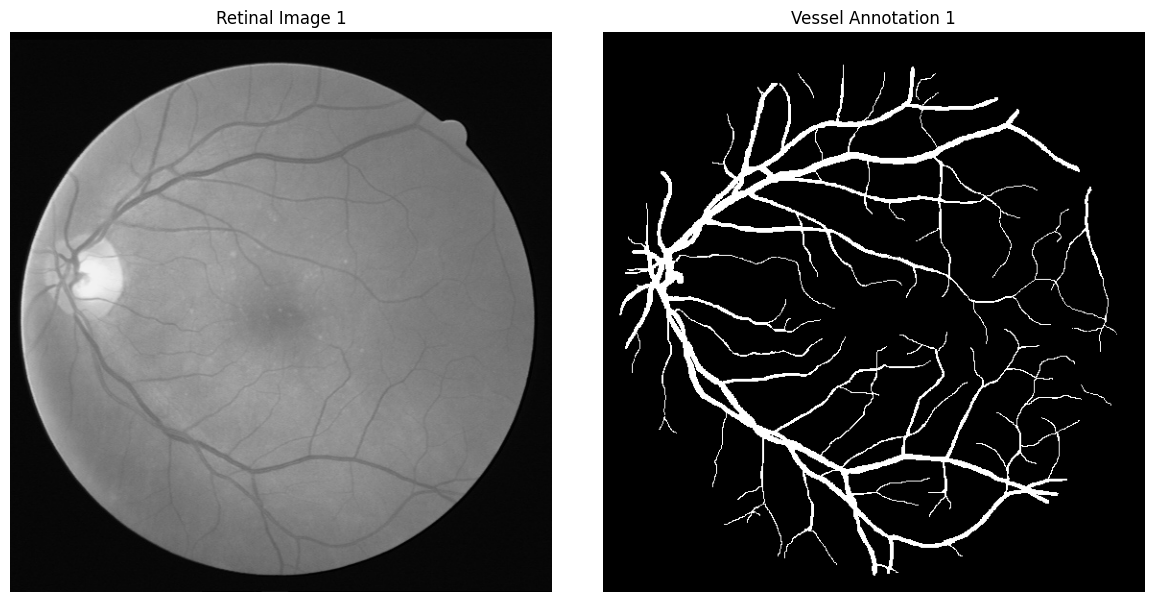

In [4]:
# Make sure I can access the directory on Colab
image = cv2.imread('/content/drive/MyDrive/Retinal_Vessal_Segmentation/training/images/21_training.tif', cv2.IMREAD_GRAYSCALE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = imageio.imread('/content/drive/MyDrive/Retinal_Vessal_Segmentation/training/1st_manual/21_manual1.gif')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Retinal Image 1")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Vessel Annotation 1")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
# Get size of image, the images aren't exactly the same dimensions, so I could use a 64x64 sliding window
print(image.shape, mask.shape)

(584, 565) (584, 565)


# Image Preprocessing

In [6]:
'''
Split images into a 128x128 patches with a stride of 64.
Some of the patches for the mask will be just a black square,
so I will filter 75% of those squares out as well
'''
def split_image(image, mask, patch_size=128, stride=64):
    h, w = image.shape
    img_patches, mask_patches = [], []
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            #print(f"Processing patch at ({i}, {j})")
            img_patch = image[i:i+patch_size, j:j+patch_size]
            #img_patches.append(img_patch)
            mask_patch = mask[i:i+patch_size, j:j+patch_size]
            #mask_patches.append(mask_patch)
            if mask_patch.sum() > 0:
                img_patches.append(img_patch)
                mask_patches.append(mask_patch)
            elif np.random.rand() < 0.25:
                img_patches.append(img_patch)
                mask_patches.append(mask_patch)
    return img_patches, mask_patches

Generated 55 image patches and 55 mask patches


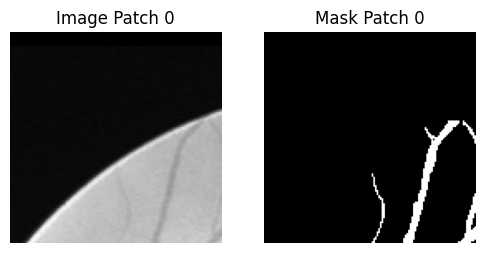

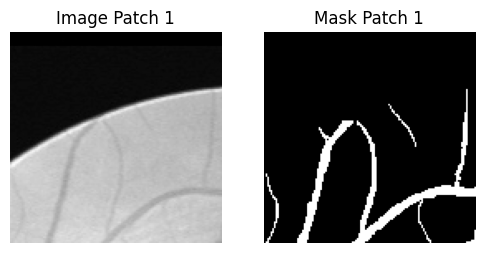

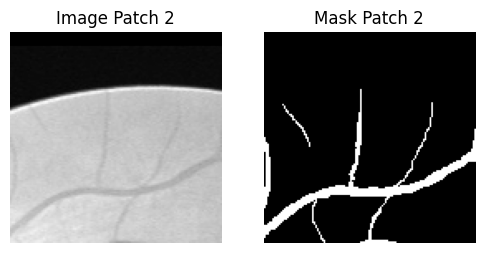

In [7]:
# Test if the patch logic works with a single image

img_patches, mask_patches = split_image(image, mask, patch_size=128, stride=64)

print(f"Generated {len(img_patches)} image patches and {len(mask_patches)} mask patches")

# Print 3 images to make sure it is printing the patches correctly
for i in range(3):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img_patches[i], cmap='gray')
    plt.title(f"Image Patch {i}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_patches[i], cmap='gray')
    plt.title(f"Mask Patch {i}")
    plt.axis("off")

    plt.show()


In [8]:
'''
This works for one image, now I have to get the ~55 patches for all 20 images,
so it will return around 1100 total patches
'''
image_dir = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/training/images/'
mask_dir = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/training/1st_manual/'

all_images = sorted([x for x in os.listdir(image_dir) if x.endswith(".tif")])
all_masks = sorted([x for x in os.listdir(mask_dir) if x.endswith(".gif")])



all_img_patches, all_mask_patches = [],[]

for img_name, mask_name in zip(all_images, all_masks):
    img_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(mask_dir, mask_name)

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = imageio.imread(mask_path) / 255.0

    img_patches, mask_patches = split_image(image, mask)
    all_img_patches.extend(img_patches)
    all_mask_patches.extend(mask_patches)

print(f"Total patches: {len(all_img_patches)}")
print(f"Patch shape: {all_img_patches[0].shape}")

Total patches: 1120
Patch shape: (128, 128)


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import numpy as np
import random

In [10]:
'''
Create a class, and make sure to have the extra dimension in the dataset
so it works with the basic U-net model
'''
class PatchDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = np.clip(self.images[idx], 0, 1).astype(np.float32)
        mask = np.clip(self.masks[idx], 0, 1).astype(np.float32)

        img_tensor = torch.from_numpy(img).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)

        return img_tensor, mask_tensor

In [11]:
# Basic Unet model with conv2d and dropout
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.2),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.2)
            )
        self.enc1 = conv_block(1, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(32, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = conv_block(64, 32)
        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = conv_block(32, 16)

        self.out_conv = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.up2(b)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return torch.sigmoid(self.out_conv(d1))


In [12]:
# F1 Score
def f1_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

In [15]:
def kfold(img_patches, mask_patches, folds=10, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X = list(img_patches)
    Y = list(mask_patches)

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    fold_scores = []
    """best_model_path = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model.pt'
    score_file_path = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model.txt'
    with open(score_file_path, 'r') as f:
        best_model = float(f.read().strip())"""
    best_model = 0.0

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{folds}")

        train_ds = PatchDataset([X[i] for i in train_idx], [Y[i] for i in train_idx])
        val_ds = PatchDataset([X[i] for i in val_idx], [Y[i] for i in val_idx])
        train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=8)

        model = UNet().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.BCELoss()

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for x, y in train_dl:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = loss_fn(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            if (epoch + 1) % 5 == 0:
              print(f"Epoch {epoch + 1} - Loss: {epoch_loss}")

        # Evaluation
        model.eval()
        val_dices = []
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                dice = f1_score(pred, y)
                val_dices.append(dice.item())

                img_np = x[0].cpu().squeeze().numpy()
                pred_np = pred[0].cpu().squeeze().numpy()
                mask_np = y[0].cpu().squeeze().numpy()

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(img_np, cmap='gray')
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(pred_np, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(mask_np, cmap='gray')
                plt.title("Actual Mask")
                plt.axis("off")

                plt.suptitle(f"Fold {fold + 1} Images")
                plt.show()

                break

        fold_score = np.mean(val_dices)
        if fold_score > best_model:
          best_model = fold_score
          best_model_path = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model_dropout.pt'
          torch.save(model.state_dict(), best_model_path)
          print(f"Saved best model to: {best_model_path} (F1 Score: {float(fold_score)})")
        print(f"Fold {fold + 1} F1 Score: {fold_score}")
        fold_scores.append(float(fold_score))

    print("\nFinal F1 Scores Range:")
    print(f"Mean F1 Score: {np.mean(fold_scores)} ± {np.std(fold_scores)}")


Fold 1/10
Epoch 5 - Loss: 24.022705271840096
Epoch 10 - Loss: 19.660054370760918
Epoch 15 - Loss: 17.969964116811752
Epoch 20 - Loss: 17.124160654842854
Epoch 25 - Loss: 16.728332668542862
Epoch 30 - Loss: 16.13274948298931
Epoch 35 - Loss: 15.614706568419933
Epoch 40 - Loss: 15.50066139549017
Epoch 45 - Loss: 15.197388656437397
Epoch 50 - Loss: 15.012790434062481


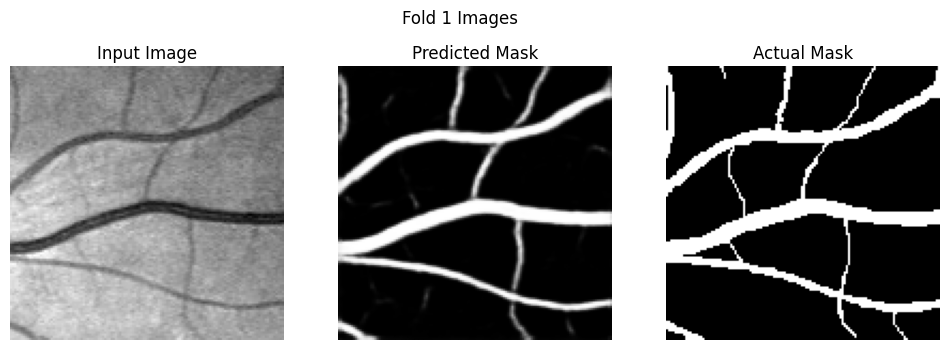

Saved best model to: /content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model_dropout.pt (F1 Score: 0.7910763025283813)
Fold 1 F1 Score: 0.7910763025283813

Fold 2/10
Epoch 5 - Loss: 21.578771524131298
Epoch 10 - Loss: 18.49574001133442
Epoch 15 - Loss: 17.474674582481384
Epoch 20 - Loss: 16.88456639647484
Epoch 25 - Loss: 16.30814006179571
Epoch 30 - Loss: 15.801992289721966
Epoch 35 - Loss: 15.623258270323277
Epoch 40 - Loss: 15.479876853525639
Epoch 45 - Loss: 15.17636239528656
Epoch 50 - Loss: 15.091563411056995


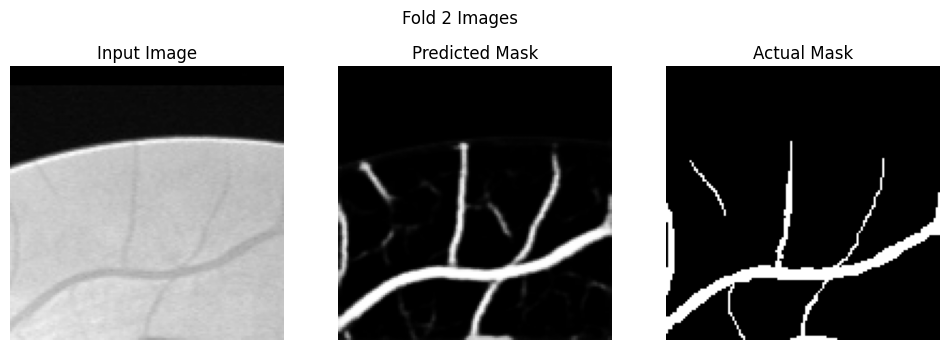

Saved best model to: /content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model_dropout.pt (F1 Score: 0.8267329335212708)
Fold 2 F1 Score: 0.8267329335212708

Fold 3/10
Epoch 5 - Loss: 22.596217811107635
Epoch 10 - Loss: 19.15310188382864
Epoch 15 - Loss: 17.718689434230328
Epoch 20 - Loss: 16.73956561088562
Epoch 25 - Loss: 16.259128414094448
Epoch 30 - Loss: 15.838833324611187
Epoch 35 - Loss: 15.56472435593605
Epoch 40 - Loss: 15.155758023262024
Epoch 45 - Loss: 14.854022949934006
Epoch 50 - Loss: 14.939146794378757


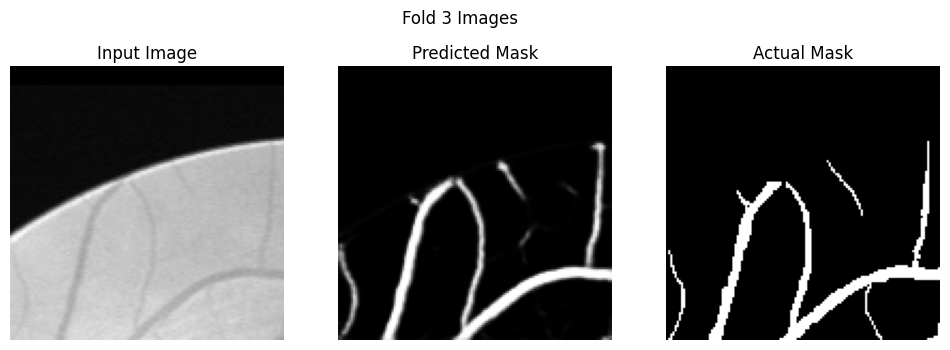

Fold 3 F1 Score: 0.8252365589141846

Fold 4/10
Epoch 5 - Loss: 23.001179844141006
Epoch 10 - Loss: 19.135781913995743
Epoch 15 - Loss: 17.950080379843712
Epoch 20 - Loss: 17.20175527781248
Epoch 25 - Loss: 16.608791910111904
Epoch 30 - Loss: 15.973924823105335
Epoch 35 - Loss: 15.784966692328453
Epoch 40 - Loss: 15.654605828225613
Epoch 45 - Loss: 15.70207754522562
Epoch 50 - Loss: 15.20463353395462


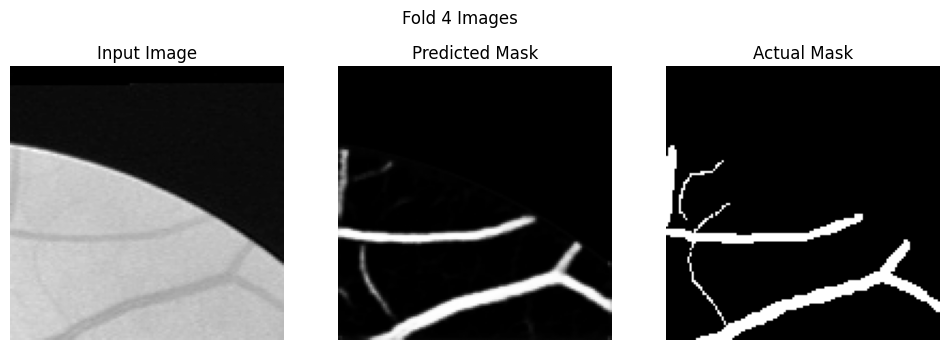

Fold 4 F1 Score: 0.7798656821250916

Fold 5/10
Epoch 5 - Loss: 25.13774360716343
Epoch 10 - Loss: 20.693386182188988
Epoch 15 - Loss: 19.447699278593063
Epoch 20 - Loss: 18.198028564453125
Epoch 25 - Loss: 17.154558047652245
Epoch 30 - Loss: 16.7307221442461
Epoch 35 - Loss: 16.077369533479214
Epoch 40 - Loss: 15.995304569602013
Epoch 45 - Loss: 15.577729865908623
Epoch 50 - Loss: 15.501915328204632


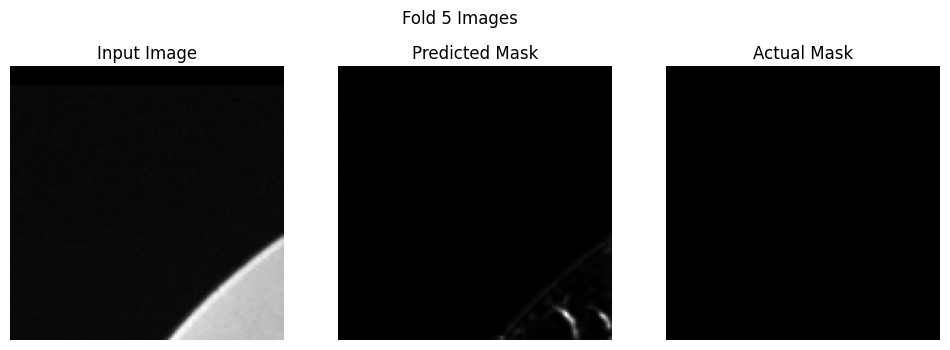

Fold 5 F1 Score: 0.7936165928840637

Fold 6/10
Epoch 5 - Loss: 22.82062354683876
Epoch 10 - Loss: 19.212758123874664
Epoch 15 - Loss: 17.712780565023422
Epoch 20 - Loss: 17.124544568359852
Epoch 25 - Loss: 16.37291296571493
Epoch 30 - Loss: 16.014861293137074
Epoch 35 - Loss: 16.08798635005951
Epoch 40 - Loss: 15.669623516499996
Epoch 45 - Loss: 15.145070105791092
Epoch 50 - Loss: 14.980821304023266


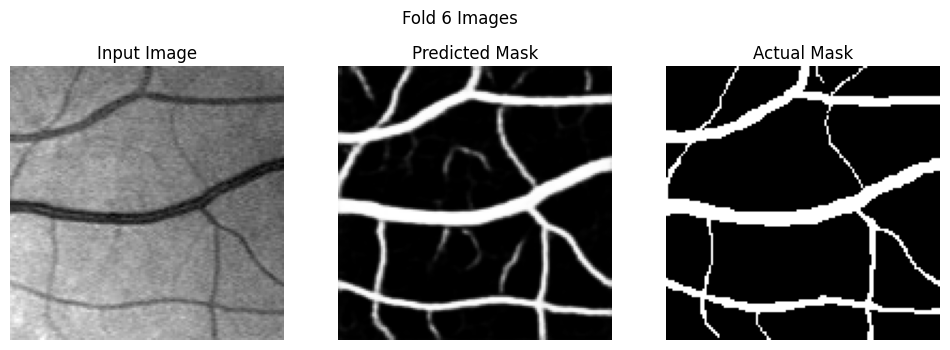

Saved best model to: /content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model_dropout.pt (F1 Score: 0.8312714099884033)
Fold 6 F1 Score: 0.8312714099884033

Fold 7/10
Epoch 5 - Loss: 23.797712922096252
Epoch 10 - Loss: 20.04309245944023
Epoch 15 - Loss: 18.041597455739975
Epoch 20 - Loss: 17.01925541460514
Epoch 25 - Loss: 16.352489471435547
Epoch 30 - Loss: 16.10969327390194
Epoch 35 - Loss: 15.647722765803337
Epoch 40 - Loss: 15.461501240730286
Epoch 45 - Loss: 15.243087612092495
Epoch 50 - Loss: 14.971190080046654


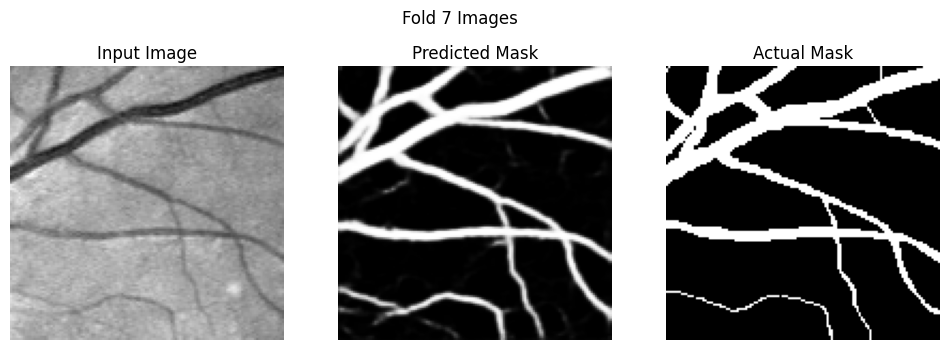

Saved best model to: /content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model_dropout.pt (F1 Score: 0.859950840473175)
Fold 7 F1 Score: 0.859950840473175

Fold 8/10
Epoch 5 - Loss: 22.53746246546507
Epoch 10 - Loss: 19.340583607554436
Epoch 15 - Loss: 18.127585493028164
Epoch 20 - Loss: 17.071958892047405
Epoch 25 - Loss: 16.49390659481287
Epoch 30 - Loss: 16.373706340789795
Epoch 35 - Loss: 15.808322295546532
Epoch 40 - Loss: 15.58397825807333
Epoch 45 - Loss: 15.442499913275242
Epoch 50 - Loss: 15.324641957879066


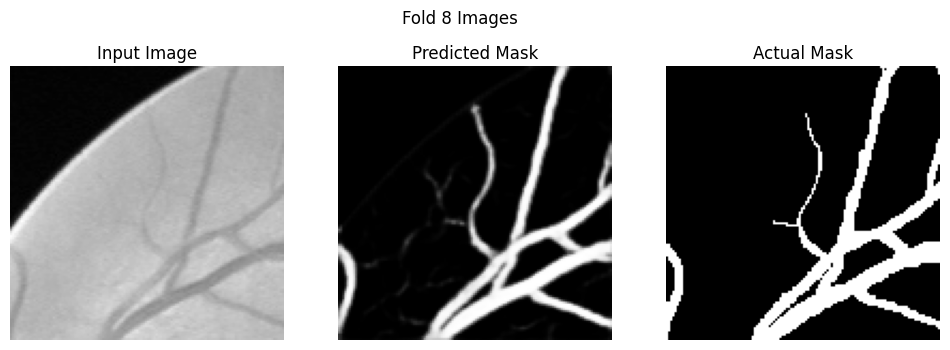

Fold 8 F1 Score: 0.8269383907318115

Fold 9/10
Epoch 5 - Loss: 23.20736961811781
Epoch 10 - Loss: 19.64413622766733
Epoch 15 - Loss: 17.848729617893696
Epoch 20 - Loss: 16.86746311187744
Epoch 25 - Loss: 16.51406592130661
Epoch 30 - Loss: 15.882804177701473
Epoch 35 - Loss: 15.587524868547916
Epoch 40 - Loss: 15.409824281930923
Epoch 45 - Loss: 15.262133218348026
Epoch 50 - Loss: 15.156783513724804


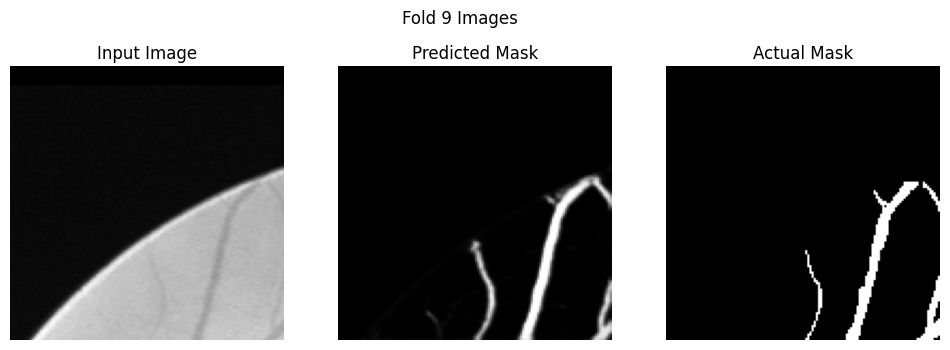

Fold 9 F1 Score: 0.7591915726661682

Fold 10/10
Epoch 5 - Loss: 22.907550796866417
Epoch 10 - Loss: 19.289435230195522
Epoch 15 - Loss: 17.99119282513857
Epoch 20 - Loss: 16.812029115855694
Epoch 25 - Loss: 16.507348775863647
Epoch 30 - Loss: 16.17100750654936
Epoch 35 - Loss: 15.785206414759159
Epoch 40 - Loss: 15.628093406558037
Epoch 45 - Loss: 15.625612020492554
Epoch 50 - Loss: 15.239923007786274


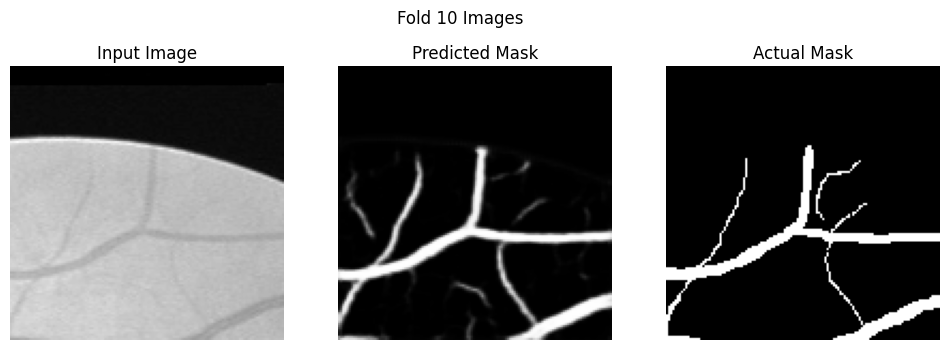

Fold 10 F1 Score: 0.8108171224594116

Final F1 Scores Range:
Mean F1 Score: 0.8104697406291962 ± 0.02803777648530849


In [16]:
kfold(all_img_patches, all_mask_patches)

In [23]:
# Try to predict a full image to see how it looks
def predict_full_image(model, full_image, patch_size=128, stride=64, device='cpu'):
    model.eval()
    h, w = full_image.shape
    output_mask = np.zeros((h, w))
    count_mask = np.zeros((h, w))
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = full_image[i:i+patch_size, j:j+patch_size]
            patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            with torch.no_grad():
                pred = model(patch_tensor).cpu().squeeze().numpy()

            output_mask[i:i+patch_size, j:j+patch_size] += pred
            count_mask[i:i+patch_size, j:j+patch_size] += 1

    output_mask = output_mask / np.maximum(count_mask, 1e-7)
    return output_mask


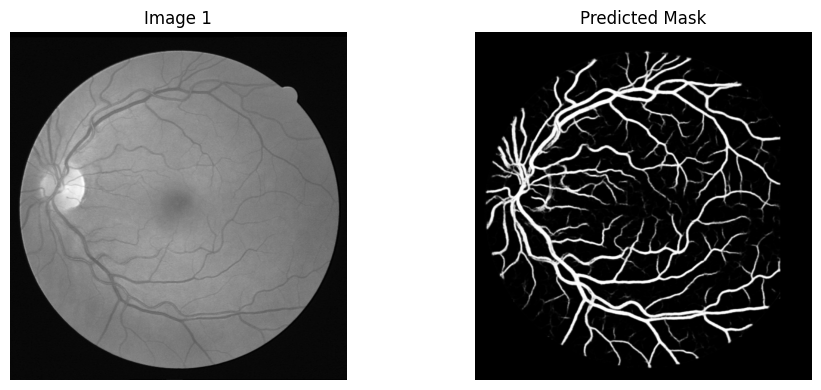

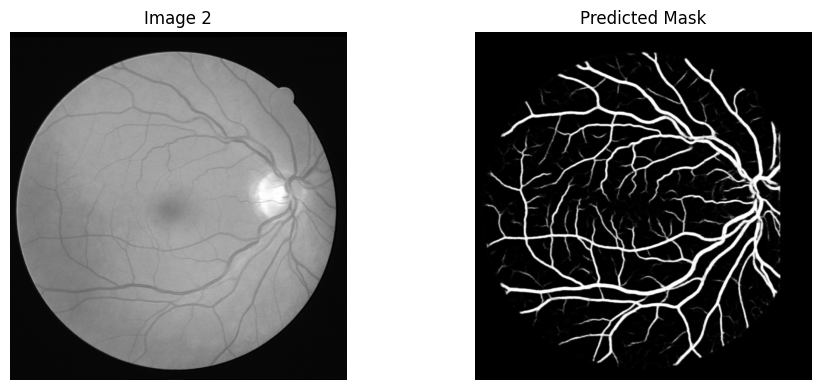

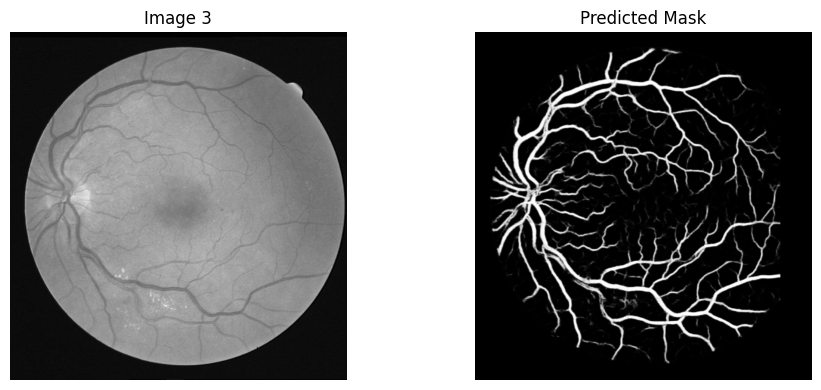

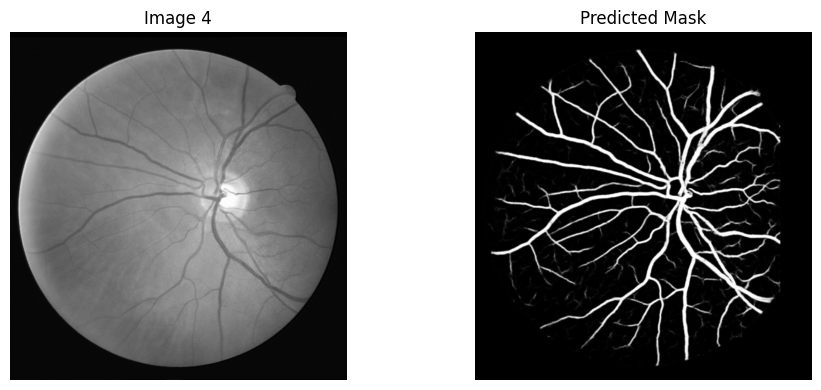

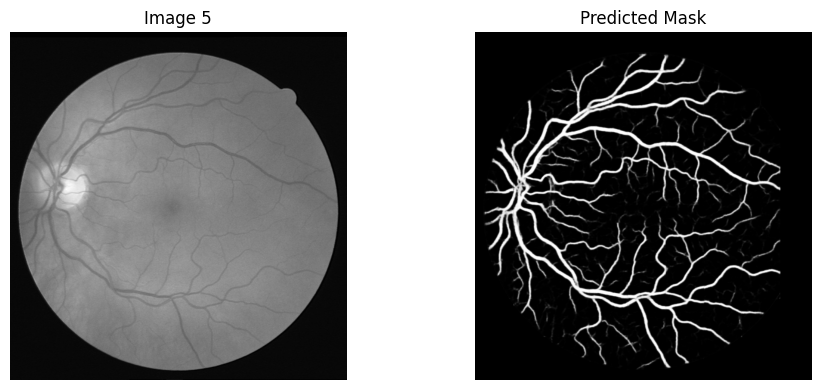

In [24]:
# Tested on 5 test images. The test images don't have any annotations, but by eyeballing it, the result it seems good

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model_dropout.pt'))
model.eval()

test_dir = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/test/images/'
test_images = sorted([f for f in os.listdir(test_dir) if f.endswith('.tif')])[:5]

for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, img_name)
    full_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0

    predicted_mask = predict_full_image(model, full_image, device=device)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(full_image, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

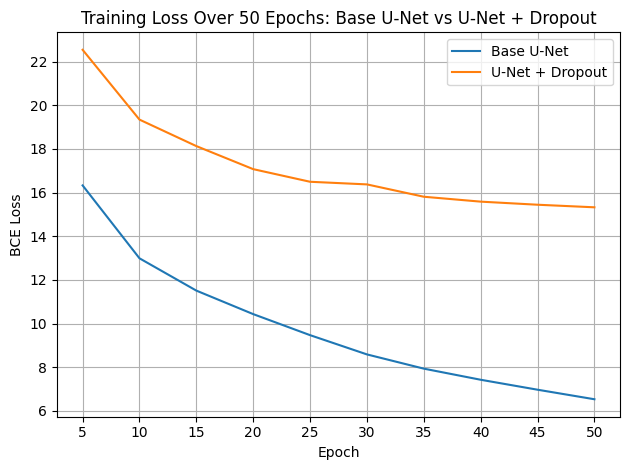

In [33]:
# For the results section, compare both the methods's loss for the best fold

base_losses = [16.32678757607937, 12.988697409629822, 11.509286522865295, 10.432915847748518, 9.469305958598852, 8.587602835148573, 7.935834363102913, 7.4269002340734005, 6.971128173172474, 6.534122981131077]
dropout_losses = [22.53746246546507, 19.340583607554436, 18.127585493028164, 17.071958892047405, 16.49390659481287, 16.373706340789795, 15.808322295546532, 15.58397825807333, 15.442499913275242, 15.324641957879066]

epochs = [5 * i for i in range(1, 11)]

plt.plot(epochs, base_losses, label='Base U-Net')
plt.plot(epochs, dropout_losses, label='U-Net + Dropout')
plt.title("Training Loss Over 50 Epochs: Base U-Net vs U-Net + Dropout")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

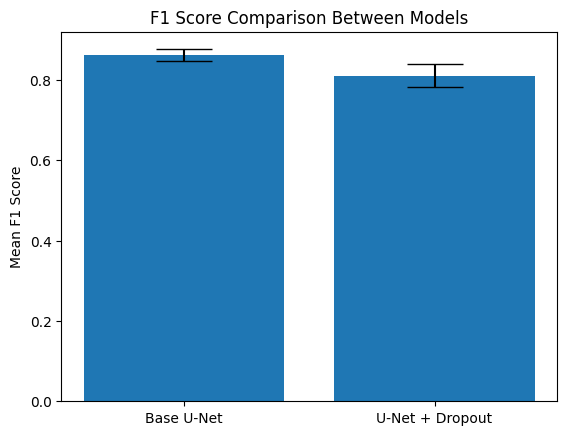

In [32]:
# Comparing F1 Scores between the models

mean_scores = [0.8610802173614502, 0.8104697406291962]
std_devs = [0.015001424311222408, 0.02803777648530849]
model_names = ['Base U-Net', 'U-Net + Dropout']

plt.bar(model_names, mean_scores, yerr=std_devs, capsize=20)

plt.ylabel("Mean F1 Score")
plt.title("F1 Score Comparison Between Models")

plt.show()